# Capstone Project 
### Applied Data Science Certification by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data) <br>
    * [a. Importing Real State Data](#importingRealStateData)
* [Methodology](#methodology)
* [Analysis and Results](#analysis)
    * [a. Feature Engineering](#featureEng)
    * [b. Data Descriptors](#dataDesc)
    * [c. Data Normalization and Modeling](#dataNorm)
    * [d. Most Important Features Found by the Model](#features)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The brazilian city of Campinas is the second biggest city in the São Paulo state. As such it contains lots of location data to be used.

For this project, the problem I want to address is to understand the **influence of different types of venues in property prices**. To do so, I will need real state data and data regarding venues surrounding these properties.

The main idea here is to generate an explanatory model that will try to explain property prices by looking at the types of venues that surround them.

## Data <a name="data"></a>

In order to develop this model I will need to look at rel state data. I will build a crawler to go through a real state website (*https://www.vivareal.com.br/*) to pull the data I need.
The main variables I will pull from this site are:
1. Property price
2. Property area (m²)
3. Number of bedrooms
4. Number of bathrooms
5. Number of Parking Spots
6. Address
7. Latitude
8. Longitude

Then I will use the coordinates and pull venues data from Foursquare website (*https://foursquare.com/*) and use the quantities of venue types as new variables for my explanatory model

In [1]:
# Importing libraries and settings
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import numpy as np
import time
from requests import get
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import folium
import requests
from IPython.display import Image

In [2]:
os.chdir('C:\\Users\\brfb\\Desktop\\tmp')
df = pd.read_csv('campinas.csv', sep='|')
df.dropna(inplace=True)
print(len(df))
df.head()

1057


,address,propertyArea,bedrooms,bathrooms,parkingSpots,price,latitude,longitude,neigborhood
4,"Avenida Brasil, 590 - Jardim Guanabara, Campin...",55,2,2,1.00,617000.00,-22.88,-47.08,Jardim Chapadão
11,"Rua Irmã Maria Inês - Jardim Chapadão, Campina...",55,2,2,1.00,490000.00,-22.89,-47.08,Jardim Chapadão
12,"Avenida Brasil, 590 - Jardim Guanabara, Campin...",55,2,2,1.00,430000.00,-22.88,-47.08,Jardim Chapadão
17,"Avenida Nossa Senhora de Fátima, 730 - Taquara...",55,2,2,1.00,1050000.00,-22.88,-47.04,Taquaral
21,"Rua Santos Dumont, 80 - Cambuí, Campinas - SP",55,2,2,1.00,390000.00,-22.89,-47.05,Cambuí


In [3]:
venues_df = pd.read_csv('campinasVenues.csv', sep='|')
venues_df.dropna(inplace=True)
print(len(venues_df))
venues_df.head()

48023


,neighborhood,latitude,longitude,venueName,vLat,vLong,vType
0,Jardim Chapadão,-22.88,-47.08,IAC Fazenda Santa Elisa,-22.87,-47.07,Outdoors & Recreation
1,Jardim Chapadão,-22.88,-47.08,Academia TL2,-22.88,-47.07,Gym / Fitness Center
2,Jardim Chapadão,-22.88,-47.08,Frango Assado - Serra Azul,-22.88,-47.07,Breakfast Spot
3,Jardim Chapadão,-22.88,-47.08,Restaurante Do Ital,-22.87,-47.08,Food
4,Jardim Chapadão,-22.89,-47.08,Bar do Carioca,-22.89,-47.08,Bar


### a. Importing Real State Data <a name="importingRealStateData"></a>   

In [4]:
# This header helps to mimic a human browsing on the internet
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
site='''https://www.vivareal.com.br/venda/sp/campinas/apartamento_residencial/?pagina={}#onde=BR-Sao_Paulo-NULL-Campinas&tipos=
            apartamento_residencial,casa_residencial,kitnet_residencial,sobrado_residencial'''.format(1)

# for a comprehensive list of responses, see: https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
response = get(site, headers=headers)
print(response)

<Response [200]>


In [5]:
html_soup = BeautifulSoup(response.text, 'html.parser')

In [6]:
# How many pages needs to be scrapped
pages=html_soup.find_all('li', class_="pagination__item")
pages_list=[]
for p in range(len(pages)):
    try:
        pages_list.append(int(pages[p].text.strip()))
    except:
        pass
    
maxpages = max(pages_list)

In [7]:
# Geolocator instance
geolocator = Nominatim(user_agent="cmpns")

In [11]:
# Lists that will contain the data
address = []
area = []
bedrooms = []
bathrooms =[]
garage = []
price = []
latt = []
long =[]
hood =[]


#Loop to retrieve data
print('Obtaining Real State Data:', end='')
for page in range(100):
    print(' .', end='')
    
    site='''https://www.vivareal.com.br/venda/sp/campinas/apartamento_residencial/?pagina={}#onde=BR-Sao_Paulo-NULL-Campinas&tipos=
            apartamento_residencial,casa_residencial,kitnet_residencial,sobrado_residencial'''.format(page+1)
    response = get(site, headers=headers)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    house_containers = html_soup.find_all('div', class_="js-card-selector")
    
    if house_containers !=[]:
        for h in range(len(house_containers)):
            #Address
            try:
                addr=house_containers[h].find('span', class_="property-card__address js-property-card-address js-see-on-map").text.strip()
                address.append(addr)
            except:
                address.append(np.nan)
                
            #Area
            try:
                ar = house_containers[0].find_all('li',class_='property-card__detail-item property-card__detail-area')[0]
                area.append(int(ar.find('span', class_="property-card__detail-value js-property-card-value property-card__detail-area js-property-card-detail-area").text.strip()) )
            except:
                area.append(np.nan)
            
            #Bedrooms
            try:
                bed = house_containers[0].find_all('li',class_='property-card__detail-item property-card__detail-room js-property-detail-rooms')[0]
                bedrooms.append(int(bed.find('span', class_="property-card__detail-value js-property-card-value").text.strip()))
            except:
                bedrooms.append(np.nan)
                
            #bathrooms
            try:
                bath = house_containers[0].find_all('li',class_='property-card__detail-item property-card__detail-bathroom js-property-detail-bathroom')[0]
                bathrooms.append(int(bath.find('span', class_="property-card__detail-value js-property-card-value").text.strip()) )
            except:
                bathrooms.append(np.nan)
            
            #Garages
            try:
                gar = house_containers[0].find_all('li',class_='property-card__detail-item property-card__detail-garage js-property-detail-garages')[0]
                garage.append(int(gar.find('span', class_="property-card__detail-value js-property-card-value").text.strip()) )
            except:
                garage.append(np.nan)
            
            #Price
            try:
                vlr=house_containers[h].find('div',class_="property-card__price js-property-card-prices js-property-card__price-small").text.strip()
                price.append(int(''.join(i for i in vlr if i in ['0','1','2','3','4','5','6','7','8','9'])) )
            except:
                price.append(np.nan)
                
            # Coordinates
            try:
                location = geolocator.geocode(addr)
                latt.append(location.latitude)
                long.append(location.longitude)
                hood.append(location.address.split(',')[1])
            except:
                latt.append(np.nan)
                long.append(np.nan)
                hood.append(np.nan)
    else:
        break

print(' Done', end='')
print('Data of {} properties where imported.'.format(len(address)))

Obtaining Real State Data: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done
Data of 1057 properties where imported.


In [207]:
# Create a dataframe with the scrapped data
df= pd.DataFrame(list(zip(address, area, bedrooms, bathrooms, garage, price, latt, long, hood)), 
             columns=['address', 'propertyArea', 'bedrooms', 'bathrooms', 'parkingSpots', 'price', 'latitude', 'longitude', 'neigborhood'])

#Drop null values
df.dropna(inplace=True)
df.head()

,address,propertyArea,bedrooms,bathrooms,parkingSpots,price,latitude,longitude,neigborhood
0,"Avenida Governador Pedro de Toledo - Bonfim, C...",55,2,2,1.0,328000.0,NaN,NaN,NaN
1,"Rua Arnaldo Barreto, 330 - São Bernardo, Campi...",55,2,2,1.0,NaN,NaN,NaN,NaN
2,"Avenida Dom Joaquim Mamede da Silva Leite, 40 ...",55,2,2,1.0,308500.0,NaN,NaN,NaN
3,"Rua Floriano Fernandes Lopes, 10 - Jardim Marg...",55,2,2,1.0,440000.0,NaN,NaN,NaN
4,"Avenida Brasil, 590 - Jardim Guanabara, Campin...",55,2,2,1.0,617000.0,-22.877043,-47.075749,Jardim Chapadão


##### Map of the properties in the city of Campinas
As seen most properties tend to cluster around the center of the city.

In [12]:
# Plotting the properties in a map
address = 'Campinas, Sao Paulo, Brazil'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['latitude'], df['longitude'], [str(p) for p in df['price']]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

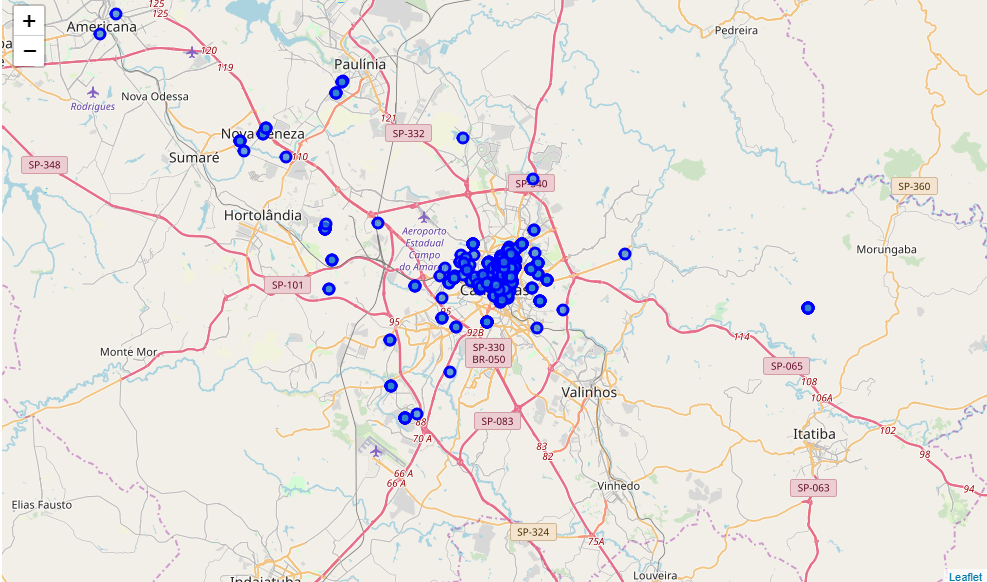

In [2]:
# Since the map may not load in some platforms, Here I load an image of the actual map
Image("img1.png")

#### Foursquare Data
Here the Foursquare API is used to fetch data for the venues surrounding the properties scrapped in the previous step.

In [225]:
# Foursquare credentials
CLIENT_ID = '' # Foursquare ID
CLIENT_SECRET = '' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [15]:
# For Loop to get venues
radius=500
LIMIT=100
names = names=df['neigborhood']
latitudes=df['latitude']
longitudes=df['longitude']
venues_list=[]

print('Fetching Venues Data: ', end='')
for name, lat, lng in zip(names, latitudes, longitudes):
    try:
        print(' .', end='')
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                    CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], 
                             v['venue']['categories'][0]['name']) for v in results])
    except:
        pass

print(' Done', end='')

Fetching Venues Data:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [297]:
# Final list with all the venues
venuesList2=[item for venue_list in venues_list for item in venue_list]

In [17]:
#Dataframe with the scrapped venues
venues_df = pd.DataFrame(venuesList2, columns=['neighborhood', 'latitude', 'longitude', 'venueName', 'vLat', 'vLong', 'vType'])
venues_df.head()

,neighborhood,latitude,longitude,venueName,vLat,vLong,vType
0,Jardim Chapadão,-22.88,-47.08,IAC Fazenda Santa Elisa,-22.87,-47.07,Outdoors & Recreation
1,Jardim Chapadão,-22.88,-47.08,Academia TL2,-22.88,-47.07,Gym / Fitness Center
2,Jardim Chapadão,-22.88,-47.08,Frango Assado - Serra Azul,-22.88,-47.07,Breakfast Spot
3,Jardim Chapadão,-22.88,-47.08,Restaurante Do Ital,-22.87,-47.08,Food
4,Jardim Chapadão,-22.89,-47.08,Bar do Carioca,-22.89,-47.08,Bar


In [11]:
print('There are {} unique categories.'.format(len(venues_df['vType'].unique())))

There are 338 unique categories.


## Methodology <a name="methodology"></a>

In the previous section I scrapped the Real State and Venues data that will be used in this analysis. The methodology I will use in this analysis is:     
    -  First, create new variables to use in the model.
    -  Second, I will see some data descriptors to get more sense of the data
    -  Next I will normalize the data that will be used in the model. For the model I will use a tree-based model, 
       Random Forest Regressor, since it generalizes well, is less susceptibe to outliers than a linear model and it does not require the data to
       follow any distribution. For these reasons I think a Random Forest model will be more robust. In order to find the best parameters, I will 
       make use of a Grid Search.
    -  Lastly I will take a look at the features that are more important in the model.

## Analysis and Results <a name="analysis"></a>

### a. Feature Engineering to use in the model <a name="featureEng"></a>

In [18]:
# Create new variables using one hot encoding
venues_onehot = pd.get_dummies(venues_df[['vType']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues_df['neighborhood']
venues_onehot['latitude']= venues_df['latitude']
venues_onehot['longitude']= venues_df['longitude']

#Summarize by neighborhood
venues_onehot=venues_onehot.groupby(['Neighborhood','latitude','longitude']).max().reset_index()
venues_onehot.head()

,Neighborhood,latitude,longitude,Acai House,Accessories Store,Adult Boutique,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Warehouse Store,Water Park,Wedding Hall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,155,-22.90,-47.07,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500,-22.89,-47.06,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,535,-22.89,-47.06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,539,-22.89,-47.05,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,577,-22.89,-47.05,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [19]:
# Join back to the original table
df_full = pd.merge(df,venues_onehot, how='left', left_on=['neigborhood', 'latitude', 'longitude'], right_on=['Neighborhood', 'latitude', 'longitude'])
df_full.drop_duplicates(inplace=True)
df_full.dropna(inplace=True)
df_full.head()

,address,propertyArea,bedrooms,bathrooms,parkingSpots,price,latitude,longitude,neigborhood,Neighborhood,...,Warehouse Store,Water Park,Wedding Hall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,"Avenida Brasil, 590 - Jardim Guanabara, Campin...",55,2,2,1.00,617000.00,-22.88,-47.08,Jardim Chapadão,Jardim Chapadão,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,"Rua Irmã Maria Inês - Jardim Chapadão, Campina...",55,2,2,1.00,490000.00,-22.89,-47.08,Jardim Chapadão,Jardim Chapadão,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,"Avenida Brasil, 590 - Jardim Guanabara, Campin...",55,2,2,1.00,430000.00,-22.88,-47.08,Jardim Chapadão,Jardim Chapadão,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,"Avenida Nossa Senhora de Fátima, 730 - Taquara...",55,2,2,1.00,1050000.00,-22.88,-47.04,Taquaral,Taquaral,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,"Rua Santos Dumont, 80 - Cambuí, Campinas - SP",55,2,2,1.00,390000.00,-22.89,-47.05,Cambuí,Cambuí,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


### b. Data Descriptors <a name="dataDesc"></a>

In [20]:
df_full.describe()

,propertyArea,bedrooms,bathrooms,parkingSpots,price,latitude,longitude,Acai House,Accessories Store,Adult Boutique,...,Warehouse Store,Water Park,Wedding Hall,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
count,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,...,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00,1011.00
mean,78.43,2.41,2.03,1.47,707068.40,-22.86,-47.07,0.21,0.02,0.00,...,0.00,0.02,0.00,0.01,0.20,0.01,0.00,0.08,0.30,0.00
std,36.32,0.65,1.19,0.62,626504.32,1.31,1.15,0.41,0.15,0.03,...,0.04,0.15,0.03,0.09,0.40,0.09,0.03,0.27,0.46,0.03
min,36.00,1.00,1.00,1.00,0.00,-24.08,-64.72,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,55.00,2.00,1.00,1.00,339316.00,-22.90,-47.06,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,68.00,2.00,2.00,1.00,526500.00,-22.89,-47.05,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,82.00,3.00,2.00,2.00,886000.00,-22.89,-47.05,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,232.00,4.00,6.00,4.00,5042000.00,-3.36,-43.86,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


It seems that the data makes sense, most properties have reasonable number of bedrooms and bathrooms, as well as parking spots. Since most of the properties are condos/appartments, it pulls down the property area average and median.

### c. Data Normalization and Modeling <a name="dataNorm"></a>

In [21]:
# Variables to be used in the linear model
columns_to_drop = ['price', 'neigborhood', 'latitude', 'longitude', 'Neighborhood', 'address']
x_columns = [c for c in df_full.columns if c not in columns_to_drop]
y_column = 'price'

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

y = np.array(df_full[y_column])
X = df_full[x_columns]

X_scaled = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.3, random_state = 123)

#Grid searh to find best parameters
param_test = {'max_depth':range(5, 20), 'n_estimators': range(5, 20, 5)}
gsearch= GridSearchCV(estimator=RandomForestRegressor(), param_grid= param_test,  n_jobs=-1, cv=5)

# even if it performs cross validation, we want to use a holdout to test
gsearch.fit(X_train,y_train)

print('The best parameters are:')
print(gsearch.best_params_)

The best parameters are:
{'max_depth': 5, 'n_estimators': 15}


In [25]:
# Final model with best parameters
rf = RandomForestRegressor(max_depth= 5, n_estimators= 15).fit(X_train, y_train)
print('Train accuracy: ',rf.score(X_train, y_train))
print('Test accuracy: ', rf.score(X_test, y_test))
print('Total features used:', len(X.columns))

Train accuracy:  0.6050865160075163
Test accuracy:  0.30396491354518873
Total features used: 341


### d. Most Important Features Found by the Model <a name="features"></a>

As seen above, we used over 340 features in our Random Forest Regressor model. In order to understand their importance in explaining the price of a property, we will take a look at the most relevant ones:

In [26]:
# 20 Most important features that explain price
feature_importance =pd.DataFrame(list(zip(list(X.columns),list(rf.feature_importances_))),columns=['variable', 'coefficient'])
feature_importance.sort_values(by='coefficient', ascending=False).head(20)

,variable,coefficient
0,propertyArea,0.15
247,Pool,0.15
34,Beer Bar,0.10
4,Acai House,0.07
40,Bistro,0.06
272,Salon / Barbershop,0.04
127,French Restaurant,0.02
51,Burger Joint,0.02
167,Indian Restaurant,0.02
2,bathrooms,0.02


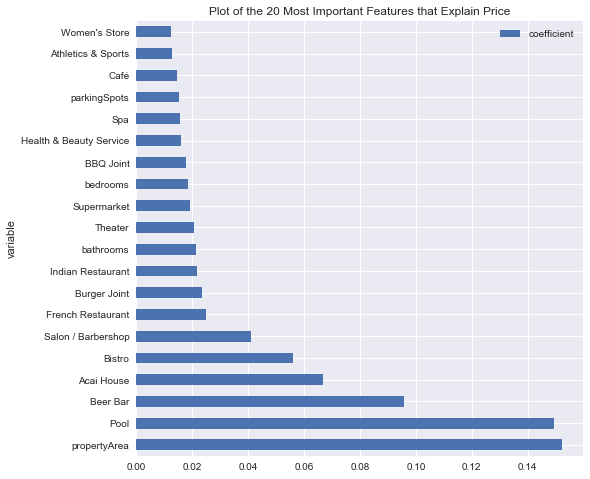

In [30]:
# Plot of the 20 most important features
plt.rcParams['figure.figsize'] = [8, 8]
feat_plt_df= feature_importance.sort_values(by='coefficient', ascending=False).head(20).set_index('variable')
feat_plt_df.plot.barh()
plt.title('Plot of the 20 Most Important Features that Explain Price');

The most important features in explaining the model seem to make sense: **pool, property area, number of bathrooms and of bedrooms and number of parking spots** do have an influence in property prices. Along with that, variables such as **Bistro, Beer Bar, Health and Beauty Services and restaurants/food places**, lead us to think that the more expensive properties tend to be located on busy areas. Usually these areas are closer to downtown and are more expensive.

##### Plotting the venues on a map will allow us to see that, like the properties, they are more clustered around the center of the metro area, which makes sense.

In [33]:
features = [f for f in feature_importance.sort_values(by='coefficient', ascending=False).head(20)['variable']]
important_venues=venues_df[venues_df['vType'].isin(features)]

In [32]:
# Plotting the venues in a map
address = 'Campinas, Sao Paulo, Brazil'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
venues_smpl= important_venues.sample(900)
map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(venues_smpl['vLat'], venues_smpl['vLong'],venues_smpl['vType']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

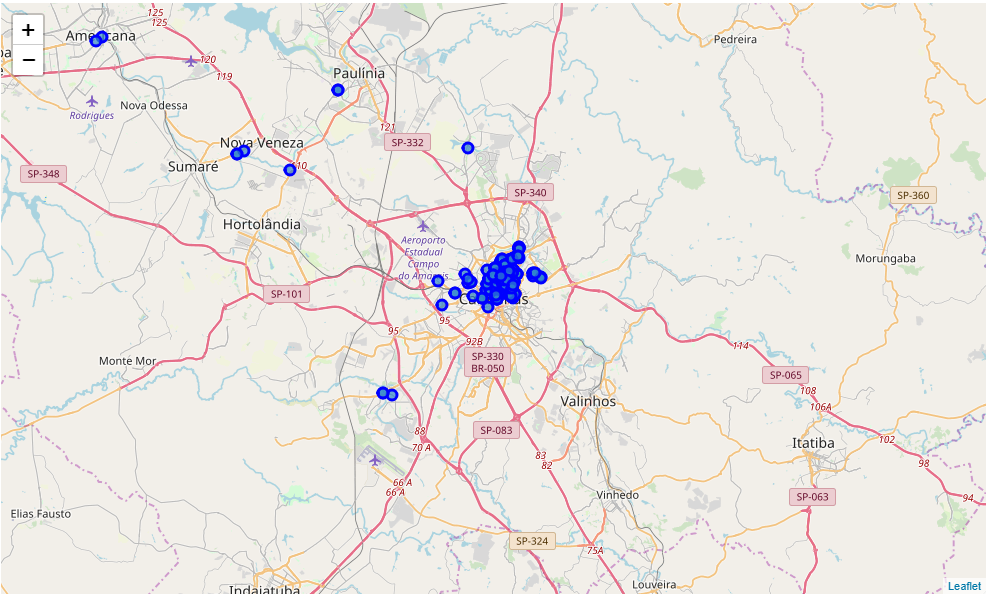

In [3]:
# Since the map may not load in some platforms, Here I load an image of the actual map
Image("img2.png")

## Conclusion <a name="conclusion"></a>

As seen, the most important features of the Random Forest model make sense. The model had an accuracy of roughly 0.6, meaning that the features can explain around 60% of the price variation in the training data. In the test data the accuracy was around 0.3.

The quest of this analysis was not to develop a predictive model that could give us unknown prices of properties, but to develop an explanatory model that can explain some of the variation in property price, given some features.

The model tells us that **property size, number of bathrooms, bedrooms and parking spots** are important and play a role in defining a house price. It told us that the proximity to some venues such as **bars and bistros, Beauty Saloons and Restaurants** also increase the price of a house, since these locations tend to be closer to busy areas/downtown.
